# Calculando as features iniciais
Neste notebook serão calculadas as features iniciais para serem utilizadas como referência para os próximos testes. Elas estão separadas em dois grupos:
1. features baseadas em estatísticas do sinal (como no estudo do LANL)
2. features baseadas em características espectrais (MFCC e STFT)


## Conectando ao Google Drive

In [ ]:
## Conectando o notebook com o Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Testando se o notebook acessa o Drive corretamente
!ls 'drive/' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'My Drive'  'Shared drives'


In [ ]:
#  Mover a pasta compartilhada para algum lugar em seu proprio drive, 
#  para conseguir acessar um atalho para o diretorio a partir daqui.

## Configurar essa variavel de ambiente (path_dados) para cada pessoa
## Meu caminho no drive (alexandre)
%env path_proj=drive/My Drive/Aulas/2019_2/ie301-projeto/projeto/

!ls "$path_proj"
!echo "-------"
!ls .

env: path_proj=drive/My Drive/Aulas/2019_2/ie301-projeto/projeto/
dados  imagens	notebooks
-------
drive		    plot_feat_corr.png	train_downsample_100.csv
plot_feat_corr.eps  sample_data


In [ ]:
## Carreando base de treino (downsampled)
!cp "$path_proj/dados/train_downsample_100.csv" .
!ls
!du -h *.csv

drive  foo.eps	plot_feat_corr.eps  sample_data		      treino.pkl
foo    foo.png	plot_feat_corr.png  train_downsample_100.csv  validacao.pkl
92M	train_downsample_100.csv


## Importando bibliotecas

In [ ]:
## Basic imports
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

## Utils
import timeit
import time
from tqdm import tqdm
import pickle

## Audio features
import librosa
import librosa.display

Populating the interactive namespace from numpy and matplotlib


## Carregando os arquivos e gerando os novos datasets

In [ ]:
df_orig = pd.read_csv('train_downsample_100.csv')

#### sinal original

In [ ]:
## Passos de 300 em 300 (overlap de 80%)
max_index = int((df_orig.shape[0]-1500) / 300)
x_orig = np.zeros([max_index, 1500])
y_orig = np.zeros(max_index)
for line in tqdm(range(max_index)):
    index = line*300
    x_orig[line, :] = df_orig.loc[index:index + 1499,
                             'acoustic_data'].values
    y_orig[line] = df_orig['time_to_failure'][index+1499]

## Configuracao de treino: holdout 80/20
holdout_index = int(y_orig.shape[0]*.80)
x_train = x_orig[:holdout_index, :]
y_train = y_orig[:holdout_index]

x_valid = x_orig[holdout_index:, :]
y_valid = y_orig[holdout_index:]

# print(y_orig.shape[0]-(y_train.shape[0]+y_valid.shape[0]))

100%|██████████| 20966/20966 [00:05<00:00, 3629.59it/s]


In [ ]:
df_train = pd.DataFrame({'y': y_train})
df_valid = pd.DataFrame({'y': y_valid})

## Sobre o cálculo das features
- As features serão calculadas, tendo em mente uma subdivisão de cada segmento em duas metades. 
- Esta divisão separando entre começo e fim do segmento pode possibilitar que as features encontradas reflitam, de uma maneira resumida, a transição temporal do fenômeno de deslizamento capturada no sinal de emissão acústica.


### Características espectrais
- MFCC
- STFT

In [ ]:
def gen_feat_mfcc(x, sub_division=2):
    """ Processa um conjunto de segmentos de sinal acustico.
        'sub_division' indica a subdivisao dos segmentos (max: 3)
        Cada sub-segmento gera 20 coeficientes Mel-cepstrais.
    """
    if(sub_division==3): 
        hop_length=301
        n_feats = 60
    elif(sub_division==2): 
        hop_length=751
        n_feats = 40
    else: 
        hop_length=1501
        n_feats = 20
    
    sample_rate = 4e4
    features = np.zeros([len(x), n_feats])

    for i in tqdm(range(len(x))):
        S = librosa.feature.melspectrogram(y = x[i,:], 
                                           sr = sample_rate, 
                                           hop_length = hop_length)
        mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
        features[i] = mfccs.ravel()
    return features

In [ ]:
## Calculando as features MFCC

mfcc_train = gen_feat_mfcc(x_train, sub_division=2)
mfcc_valid = gen_feat_mfcc(x_valid, sub_division=2)

100%|██████████| 4194/4194 [00:25<00:00, 167.66it/s]


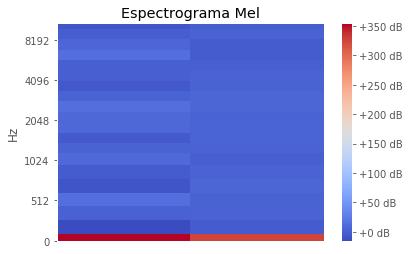

In [ ]:
## Espectrograma Mel
with plt.style.context('ggplot'):
    librosa.display.specshow(mfcc_train[0].reshape([20,2]), 
                            y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    plt.title('Espectrograma Mel');
    savefig('graf_coef_mfcc.eps', dpi=400, format='eps')
    savefig('graf_coef_mfcc.png', dpi=400, format='png')

In [ ]:
## adicionando ao DataFrame
col_mfcc = ['y']
for n in tqdm(range(mfcc_train.shape[1])):
    name = 'MFCC_'+'{:02d}'.format(n+1)
    df_train[name] = mfcc_train[:,n]
    df_valid[name] = mfcc_valid[:,n]
    col_mfcc.append(name)

100%|██████████| 40/40 [00:00<00:00, 527.01it/s]


### Características estatísticas
- Variância
- Curtose (kurtosis)

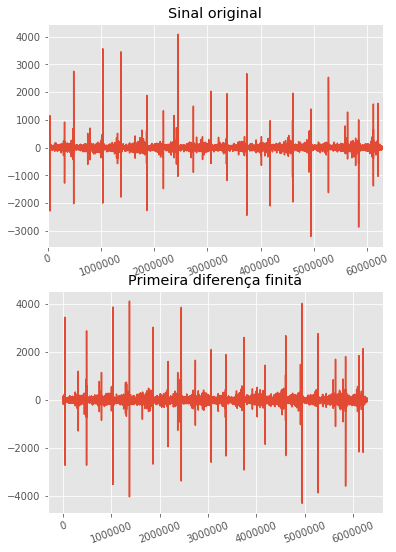

In [ ]:
with plt.style.context('ggplot'):
    figsize(6,9)
    subplot(211)
    plt.title('Sinal original')
    df_orig['acoustic_data'].plot()
    plt.xticks(rotation=20);
    
    subplot(212)
    plt.title('Primeira diferença finita')
    df_diff = df_orig['acoustic_data'][1:-1].values - df_orig['acoustic_data'][0:-2].values
    plt.plot(df_diff)
    plt.xticks(rotation=20);
    savefig('plot_sinal_normal_vs_dif.eps', dpi=400, format='eps')
    savefig('plot_sinal_normal_vs_dif.png', dpi=400, format='png')

In [ ]:
## (to do) plotar novamente o histograma de valores dos sinais

#### primeira diferença finita

In [ ]:
## Passos de 300 em 300 (overlap de 80%)
max_index = int((df_diff.shape[0]-1500) / 300)
x_diff = np.zeros([max_index, 1500])
y_diff = np.zeros(max_index)
for line in tqdm(range(max_index)):
    index = line*300
    x_diff[line, :] = df_diff.loc[index:index + 1499,
                             'acoustic_data'].values
    y_diff[line] = df_diff['time_to_failure'][index+1499]

## Configuracao de treino: holdout 80/20
holdout_index = int(y_diff.shape[0]*.80)
x_train_dif = x_diff[:holdout_index, :]
y_train_dif = y_diff[:holdout_index]

x_valid_dif = x_diff[holdout_index:, :]
y_valid_dif = y_diff[holdout_index:]

# print(y_orig.shape[0]-(y_train.shape[0]+y_valid.shape[0]))

In [ ]:
## Dividindo os segmentos em (L)eft e (R)ight
metade_segmento = int(x_train.shape[1]/2) # 750
x_train_l = x_train_dif[:, :metade_segmento]
x_train_r = x_train_dif[:, metade_segmento:]
x_valid_l = x_valid_dif[:, :metade_segmento]
x_valid_r = x_valid_dif[:, metade_segmento:]

In [ ]:
## Variancia
# treino
df_train['VAR_L'] = np.var(x_train_l, axis=1)
df_train['VAR_R'] = np.var(x_train_r, axis=1)
# valid
df_valid['VAR_L'] = np.var(x_valid_l, axis=1)
df_valid['VAR_R'] = np.var(x_valid_r, axis=1)

col_stats = ['y']
col_stats.append('VAR_L')
col_stats.append('VAR_R')

In [ ]:
## Curtose
# treino
df_train['KURT_L'] = st.kurtosis(x_train_l, axis=1)
df_train['KURT_R'] = st.kurtosis(x_train_r, axis=1)
# valid
df_valid['KURT_L'] = st.kurtosis(x_valid_l, axis=1)
df_valid['KURT_R'] = st.kurtosis(x_valid_r, axis=1)

col_stats.append('KURT_L')
col_stats.append('KURT_R')

In [ ]:
## Quantil
# Treino
# (daria pra fazer por algum loop, mas achei que ficaria confuso)
df_train['Q_01_L'] = np.quantile(x_train_l, 0.01, axis=1)
df_train['Q_05_L'] = np.quantile(x_train_l, 0.05, axis=1)
df_train['Q_10_L'] = np.quantile(x_train_l, 0.10, axis=1)
df_train['Q_90_L'] = np.quantile(x_train_l, 0.90, axis=1)
df_train['Q_95_L'] = np.quantile(x_train_l, 0.95, axis=1)
df_train['Q_99_L'] = np.quantile(x_train_l, 0.99, axis=1)

df_train['Q_01_R'] = np.quantile(x_train_r, 0.01, axis=1)
df_train['Q_05_R'] = np.quantile(x_train_r, 0.05, axis=1)
df_train['Q_10_R'] = np.quantile(x_train_r, 0.10, axis=1)
df_train['Q_90_R'] = np.quantile(x_train_r, 0.90, axis=1)
df_train['Q_95_R'] = np.quantile(x_train_r, 0.95, axis=1)
df_train['Q_99_R'] = np.quantile(x_train_r, 0.99, axis=1)

# Valid
df_valid['Q_01_L'] = np.quantile(x_valid_l, 0.01, axis=1)
df_valid['Q_05_L'] = np.quantile(x_valid_l, 0.05, axis=1)
df_valid['Q_10_L'] = np.quantile(x_valid_l, 0.10, axis=1)
df_valid['Q_90_L'] = np.quantile(x_valid_l, 0.90, axis=1)
df_valid['Q_95_L'] = np.quantile(x_valid_l, 0.95, axis=1)
df_valid['Q_99_L'] = np.quantile(x_valid_l, 0.99, axis=1)

df_valid['Q_01_R'] = np.quantile(x_valid_r, 0.01, axis=1)
df_valid['Q_05_R'] = np.quantile(x_valid_r, 0.05, axis=1)
df_valid['Q_10_R'] = np.quantile(x_valid_r, 0.10, axis=1)
df_valid['Q_90_R'] = np.quantile(x_valid_r, 0.90, axis=1)
df_valid['Q_95_R'] = np.quantile(x_valid_r, 0.95, axis=1)
df_valid['Q_99_R'] = np.quantile(x_valid_r, 0.99, axis=1)

col_stats.append('Q_01_L')
col_stats.append('Q_05_L')
col_stats.append('Q_10_L')
col_stats.append('Q_90_L')
col_stats.append('Q_95_L')
col_stats.append('Q_99_L')
col_stats.append('Q_01_R')
col_stats.append('Q_05_R')
col_stats.append('Q_10_R')
col_stats.append('Q_90_R')
col_stats.append('Q_95_R')
col_stats.append('Q_99_R')

In [ ]:
## Threshold (amostras alem do threshold, dentro do segmento de 1500 pontos)
# treino
df_train['TH_P010_L'] = np.apply_along_axis(lambda x: np.sum(x > 10), 1, x_train_l)
df_train['TH_P020_L'] = np.apply_along_axis(lambda x: np.sum(x > 20), 1, x_train_l)
df_train['TH_P040_L'] = np.apply_along_axis(lambda x: np.sum(x > 40), 1, x_train_l)
df_train['TH_P080_L'] = np.apply_along_axis(lambda x: np.sum(x > 80), 1, x_train_l)
df_train['TH_P160_L'] = np.apply_along_axis(lambda x: np.sum(x > 160), 1, x_train_l)
df_train['TH_N010_L'] = np.apply_along_axis(lambda x: np.sum(x <-10), 1, x_train_l)
df_train['TH_N020_L'] = np.apply_along_axis(lambda x: np.sum(x <-20), 1, x_train_l)
df_train['TH_N040_L'] = np.apply_along_axis(lambda x: np.sum(x <-40), 1, x_train_l)
df_train['TH_N080_L'] = np.apply_along_axis(lambda x: np.sum(x <-80), 1, x_train_l)
df_train['TH_N160_L'] = np.apply_along_axis(lambda x: np.sum(x <-160), 1, x_train_l)

df_train['TH_P010_R'] = np.apply_along_axis(lambda x: np.sum(x > 10), 1, x_train_r)
df_train['TH_P020_R'] = np.apply_along_axis(lambda x: np.sum(x > 20), 1, x_train_r)
df_train['TH_P040_R'] = np.apply_along_axis(lambda x: np.sum(x > 40), 1, x_train_r)
df_train['TH_P080_R'] = np.apply_along_axis(lambda x: np.sum(x > 80), 1, x_train_r)
df_train['TH_P160_R'] = np.apply_along_axis(lambda x: np.sum(x > 160), 1, x_train_r)
df_train['TH_N010_R'] = np.apply_along_axis(lambda x: np.sum(x <-10), 1, x_train_r)
df_train['TH_N020_R'] = np.apply_along_axis(lambda x: np.sum(x <-20), 1, x_train_r)
df_train['TH_N040_R'] = np.apply_along_axis(lambda x: np.sum(x <-40), 1, x_train_r)
df_train['TH_N080_R'] = np.apply_along_axis(lambda x: np.sum(x <-80), 1, x_train_r)
df_train['TH_N160_R'] = np.apply_along_axis(lambda x: np.sum(x <-160), 1, x_train_r)

# valid
df_valid['TH_P010_L'] = np.apply_along_axis(lambda x: np.sum(x > 10), 1, x_valid_l)
df_valid['TH_P020_L'] = np.apply_along_axis(lambda x: np.sum(x > 20), 1, x_valid_l)
df_valid['TH_P040_L'] = np.apply_along_axis(lambda x: np.sum(x > 40), 1, x_valid_l)
df_valid['TH_P080_L'] = np.apply_along_axis(lambda x: np.sum(x > 80), 1, x_valid_l)
df_valid['TH_P160_L'] = np.apply_along_axis(lambda x: np.sum(x > 160), 1, x_valid_l)
df_valid['TH_N010_L'] = np.apply_along_axis(lambda x: np.sum(x <-10), 1, x_valid_l)
df_valid['TH_N020_L'] = np.apply_along_axis(lambda x: np.sum(x <-20), 1, x_valid_l)
df_valid['TH_N040_L'] = np.apply_along_axis(lambda x: np.sum(x <-40), 1, x_valid_l)
df_valid['TH_N080_L'] = np.apply_along_axis(lambda x: np.sum(x <-80), 1, x_valid_l)
df_valid['TH_N160_L'] = np.apply_along_axis(lambda x: np.sum(x <-160), 1, x_valid_l)

df_valid['TH_P010_R'] = np.apply_along_axis(lambda x: np.sum(x > 10), 1, x_valid_r)
df_valid['TH_P020_R'] = np.apply_along_axis(lambda x: np.sum(x > 20), 1, x_valid_r)
df_valid['TH_P040_R'] = np.apply_along_axis(lambda x: np.sum(x > 40), 1, x_valid_r)
df_valid['TH_P080_R'] = np.apply_along_axis(lambda x: np.sum(x > 80), 1, x_valid_r)
df_valid['TH_P160_R'] = np.apply_along_axis(lambda x: np.sum(x > 160), 1, x_valid_r)
df_valid['TH_N010_R'] = np.apply_along_axis(lambda x: np.sum(x <-10), 1, x_valid_r)
df_valid['TH_N020_R'] = np.apply_along_axis(lambda x: np.sum(x <-20), 1, x_valid_r)
df_valid['TH_N040_R'] = np.apply_along_axis(lambda x: np.sum(x <-40), 1, x_valid_r)
df_valid['TH_N080_R'] = np.apply_along_axis(lambda x: np.sum(x <-80), 1, x_valid_r)
df_valid['TH_N160_R'] = np.apply_along_axis(lambda x: np.sum(x <-160), 1, x_valid_r)

col_stats.append('TH_P010_L')
col_stats.append('TH_P020_L')
col_stats.append('TH_P040_L')
col_stats.append('TH_P080_L')
col_stats.append('TH_P160_L')
col_stats.append('TH_N010_L')
col_stats.append('TH_N020_L')
col_stats.append('TH_N040_L')
col_stats.append('TH_N080_L')
col_stats.append('TH_N160_L')

col_stats.append('TH_P010_R')
col_stats.append('TH_P020_R')
col_stats.append('TH_P040_R')
col_stats.append('TH_P080_R')
col_stats.append('TH_P160_R')
col_stats.append('TH_N010_R')
col_stats.append('TH_N020_R')
col_stats.append('TH_N040_R')
col_stats.append('TH_N080_R')
col_stats.append('TH_N160_R')

# foo = np.apply_along_axis(lambda x: np.sum(x > 80), 1, x_train)
# plt.hist(foo, bins=50);

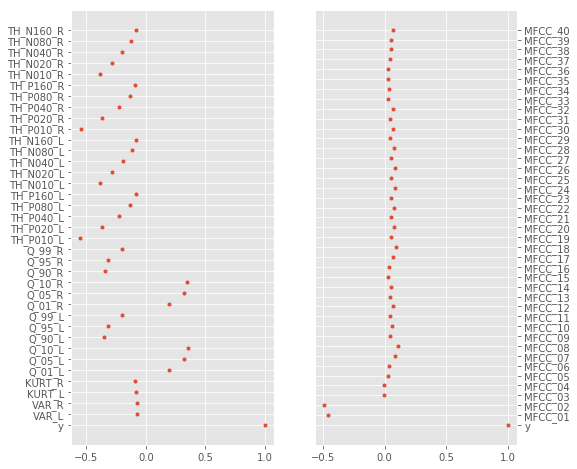

In [ ]:
with plt.style.context('ggplot'):
    figsize(8,8)
    ax1 = subplot(121)
    df = df_train[col_stats]
    ax = plt.plot(df.corr()['y'].values, np.arange(df.shape[1]), '.');
    plt.grid(True)
    plt.yticks(np.arange(df.shape[1]), col_stats, rotation='horizontal');
    ax2 = subplot(122)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    df = df_train[col_mfcc]
    plt.plot(df.corr()['y'].values, np.arange(df.shape[1]), '.');
    plt.grid(True)
    plt.yticks(np.arange(df.shape[1]), col_mfcc, rotation='horizontal');

    savefig('plot_feat_corr.eps', dpi=400, format='eps')
    savefig('plot_feat_corr.png', dpi=400, format='png')


## Gravando arquivos finais

In [ ]:
## Backup dos arquivos
# !cp *.pkl "$path_proj/dados/"
!cp *.eps "$path_proj/imagens/"
!cp *.png "$path_proj/imagens/"

In [ ]:
## Gravando as features
with open('features.pkl', 'wb') as f:
    feats = {'df_train' : df_train, 
             'df_valid' : df_valid, 
             'col_stats' : col_stats, 
             'col_mfcc' : col_mfcc}
    pickle.dump(feats, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

!cp features.pkl "$path_proj/dados/"
!du -h *.pkl
# with open('arquivo.pkl', 'rb') as f:
#     variaveis = pickle.load(f)
#     f.close()

13M	features.pkl
0	final_model.pkl


In [ ]:
## Gravando as features
with open('x_segments.pkl', 'wb') as f:
    X = {'x_train':x_train,
         'x_valid':x_valid}
    pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

!cp x_segments.pkl "$path_proj/dados/"
!du -h *.pkl

13M	features.pkl
0	final_model.pkl
240M	x_segments.pkl


In [ ]:
# with open('features.pkl', 'rb') as f:
#     foo = pickle.load(f)
#     f.close()
# foo.keys()
# foo['col_mfcc']

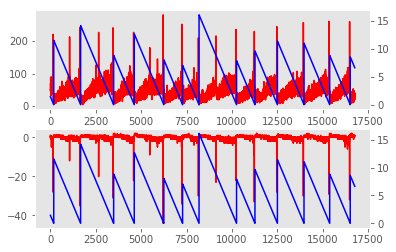

In [ ]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(211)

    ax.plot(df_train['TH_P010_L'].values, '-r')
    ax.grid(False)
    ax2 = ax.twinx()
    ax2.plot(df_train['y'].values, '-b');
    ax2.grid(False)

    ax = fig.add_subplot(212)
    ax.plot(df_train['Q_10_L'].values, '-r')
    ax.grid(False)
    ax2 = ax.twinx()
    ax2.plot(df_train['y'].values, '-b');
    ax2.grid(False)